In [1]:
import numpy as np

from dask.delayed import delayed
from dask.base import compute
from dask.diagnostics.progress import ProgressBar

from symbolic_regression.methods.gp import GP
from symbolic_regression.methods.gpshap import GPSHAP
from symbolic_regression.methods.gpcmi import GPCMI
from symbolic_regression.methods.rfgp import RFGP

from symbolic_regression.utils.pysr_utils import nrmse_loss, train_val_test_split, process_task
from symbolic_regression.utils.pysr_utils import results_to_dataframe, plot_results

from symbolic_regression.datasets import load_datasets

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

sns.set_theme()
warnings.filterwarnings("ignore", category=UserWarning, module="pysr")
warnings.filterwarnings("ignore", category=RuntimeWarning)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
n_runs = 100
test_size = 0.2
val_size = 0.25
n_top_features = None
ns = 100
ci = 0.99
k = 5
record_interval = 5
n_submodels = 3

pysr_params = {
    "populations": 3,
    "population_size": 33,
    "niterations": 150,
    "binary_operators": ["+", "-", "*"],
    "unary_operators": ["sqrt", "inv(x) = 1/x"],
    "extra_sympy_mappings": {"inv": lambda x: 1/x},
    "verbosity": 0,
}

dataset_names = [
    # "F1",
    # "F2",
    # ("4544_GeographicalOriginalofMusic", "4544_GOM"),
    # "505_tecator",
    ("Communities and Crime", "CCN"),
    # ("Communities and Crime Unnormalized", "CCUN"),
]

datasets = load_datasets(dataset_names)
datasets.keys()

dict_keys(['CCN'])

In [3]:
gp_params = {
    "loss_function": nrmse_loss,
    "record_interval": record_interval,
    **pysr_params,
}

gpshap_params = {
    **gp_params
}

gpcmi_params = {
    "ns": ns,
    "ci": ci,
    "k": k,
    **gp_params
}

shap_params = {
    "test_size": test_size,
    "val_size": val_size,
    "n_runs": n_runs,
    "n_top_features": n_top_features,
    **gp_params,
}

rfgpcmi_params = {
    "n_submodels": n_submodels,
    "method_class": GPCMI,
    "method_params": gpcmi_params
}

rfgpshap_params = {
    "n_submodels": n_submodels,
    "method_class": GPSHAP,
    "method_params": gpshap_params
}

In [4]:
gp = GP(**gp_params)
gpshap = GPSHAP(**gpshap_params)
gpcmi = GPCMI(**gpcmi_params)
rfgpcmi = RFGP(**rfgpcmi_params)
# rfgpshap = RFGP(**rfgpshap_params)

methods = {
    "GP": gp,
    "GPSHAP": gpshap,
    "GPCMI": gpcmi,
    "RFGPCMI": rfgpcmi,
    # "RFGPSHAP": rfgpshap,
}

width_method = max([round(len(name), 0) for name in methods.keys()])
width_dataset = max([round(len(name), 0) for name in datasets.keys()])

n_records = methods[list(methods.keys())[0]].n_records
n_records

30

In [ ]:
# Sequential execution of tasks

results = {}
equations = {}
features = {}
if "GPSHAP" in methods:
    methods["GPSHAP"].clear_cache()  # Clear cache before starting new tasks

for dataset_name, dataset in datasets.items():
    results[dataset_name] = {}
    equations[dataset_name] = {}
    features[dataset_name] = {}
    train_val_test_sets = []

    X = dataset["X"]
    y = dataset["y"]

    for _ in range(n_runs):
        train_val_test_set = train_val_test_split(X, y)
        train_val_test_sets.append(train_val_test_set)

    for method_name, method in methods.items():
        results[dataset_name][method_name] = {
            "training_losses": np.empty((n_runs, n_records)),
            "validation_losses": np.empty((n_runs, n_records)),
            "test_losses": np.empty((n_runs, n_records)),
        }
        equations[dataset_name][method_name] = []
        features[dataset_name][method_name] = []

        print(f"Running {method_name:<{width_method}} on {dataset_name:<{width_dataset}} ", end="")

        if (method_name == "GPSHAP"):
            if equations[dataset_name].get('GP', False):
                X_trains = tuple([train_val_test_set[0] for train_val_test_set in train_val_test_sets])
                gp_equations = [eqs[-1] for eqs in equations[dataset_name]['GP']]
                
                method.precompute_features_from_pretrained_models(X_trains, gp_equations, n_top_features)
            
            else: method.precompute_features(X, y, **shap_params)

        for run in range(n_runs):
            print(".", end="")

            temp_losses, temp_best_eqs, temp_features = method.run(
                train_val_test_sets[run]
            )

            results[dataset_name][method_name]["training_losses"][run, :] = temp_losses[0]
            results[dataset_name][method_name]["validation_losses"][run, :] = temp_losses[1]
            results[dataset_name][method_name]["test_losses"][run, :] = temp_losses[2]
            equations[dataset_name][method_name].append(temp_best_eqs)
            features[dataset_name][method_name].append(temp_features)

        print("Done")

Running GP      on CCN ...

KeyboardInterrupt: 

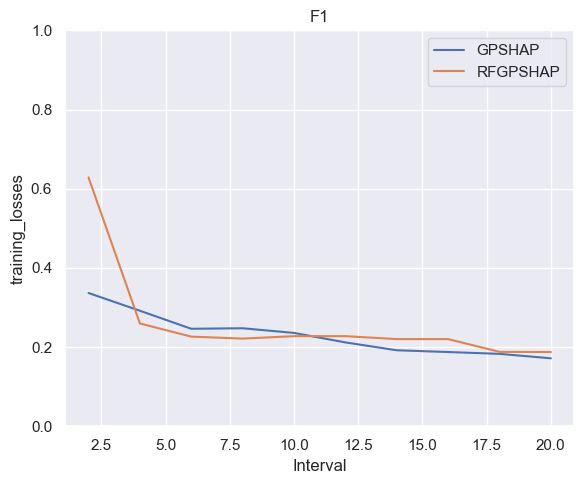

In [6]:
metrics = 'training_losses'
# metrics = 'validation_losses'
# metrics = 'test_losses'
n_datasets = len(results)
# record_interval = gp_params['record_interval']
fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))

if n_datasets == 1:
    axes = [axes]  # Ensure axes is always iterable

for ax, (dataset_name, dataset_results) in zip(axes, results.items()):
    # Get the number of intervals from any method (they should all be the same)
    method = next(iter(dataset_results))
    length = len(dataset_results[method][metrics].mean(axis=0))


    for method in dataset_results.keys():
        ax.plot(
            range(record_interval, length * record_interval + 1, record_interval),
            np.mean(dataset_results[method][metrics], axis=0),
            # dataset_results[method][metrics],
            label=method
        )
    ax.set_title(dataset_name)
    ax.set_xlabel("Interval")
    # ax.set_yscale("log")
    ax.legend()

axes[0].set_ylabel(metrics)
axes[0].set_ylim((0, 1))  # Adjust y-axis limits for better visibility
plt.tight_layout()

plt.show()

In [ ]:
# NOTE: The following code is for parallel processing of tasks across datasets and methods.

delayed_tasks = {}
if "GPSHAP" in methods:
    methods["GPSHAP"].clear_cache()  # Clear cache before starting new task

for dataset_name, dataset in datasets.items():
    delayed_tasks[dataset_name] = {}

    X = dataset["X"]
    y = dataset["y"]

    delayed_splits = [delayed(train_val_test_split)(X, y) for _ in range(n_runs)]
    
    for method_name, method in methods.items():
        delayed_tasks[dataset_name][method_name] = []

        if method_name == "GPSHAP": continue  # Skip GPSHAP for now, as it requires precomputed features

        # Create a delayed task for each method and dataset
        for run in range(n_runs):
            delayed_tasks[dataset_name][method_name].append(
                delayed(process_task)(dataset_name, method_name, run, delayed_splits[run], method)
            )
    
    if ("GPSHAP" in methods):
        if ('GP' in methods):
            delayed_X_trains = tuple([delayed_split[0] for delayed_split in delayed_splits])
            delayed_gp_equations = [delayed_task['equations'][-1] for delayed_task in delayed_tasks[dataset_name]["GP"]]
            
            # Use GP's equations for GPSHAP
            delayed_precomputed_features_task = delayed(methods["GPSHAP"].precompute_features_from_pretrained_models)(
                delayed_X_trains, delayed_gp_equations, n_top_features
            )

        else:
            delayed_precomputed_features_task = delayed(methods["GPSHAP"].precompute_features)(
                X, y, **shap_params
            )

        for run in range(n_runs):
            delayed_tasks[dataset_name]["GPSHAP"].append(
                delayed(process_task)(dataset_name, 'GPSHAP', run, delayed_splits[run], methods["GPSHAP"], delayed_precomputed_features_task)
            )

tasks_to_run = [
    task 
    for methods_dict in delayed_tasks.values() 
    for task_list in methods_dict.values() 
    for task in task_list
]

with ProgressBar():
    computed_results = compute(*tasks_to_run, scheduler='processes')

results = {}
equations = {}
features = {}

for dataset_name in datasets.keys():
    results[dataset_name] = {}
    equations[dataset_name] = {}
    features[dataset_name] = {}

    for method_name in methods.keys():
        results[dataset_name][method_name] = {
            "training_losses": np.empty((n_runs, n_records)),
            "validation_losses": np.empty((n_runs, n_records)),
            "test_losses": np.empty((n_runs, n_records)),
        }
        equations[dataset_name][method_name] = []
        features[dataset_name][method_name] = []

for result in computed_results:
    dataset_name = result['dataset_name']
    method_name = result['method_name']
    run = result['run']
    
    results[dataset_name][method_name]["training_losses"][run, :] = result['losses'][0]
    results[dataset_name][method_name]["validation_losses"][run, :] = result['losses'][1]   
    results[dataset_name][method_name]["test_losses"][run, :] = result['losses'][2]
    
    equations[dataset_name][method_name].append(result['equations'])
    features[dataset_name][method_name].append(result['features'])

In [79]:
dataset_name = list(datasets.keys())[0]
method_name = list(methods.keys())[0]
run = 1

filename = f"results_{dataset_name}_{method_name}_{run}.pkl"
filename

'results_CCN_GP_1.pkl'

In [75]:
method_name

'X'

In [9]:
data = {
    "results": results,
    "equations": equations,
    "features": features
}
timestamp = datetime.datetime.now().strftime("%Y-%m-%d__%H-%M-%S")
filename = f"data_{timestamp}.pickle"
with open(filename, "wb") as f:
    pickle.dump(data, f)
print(f"\nResults saved to {filename}")

NameError: name 'results' is not defined

In [5]:
import pickle
import datetime

data = pickle.load(open('data_2025-09-19__04-53-03.pickle', "rb"))
results, features, equations = data['results'], data['features'], data['equations']

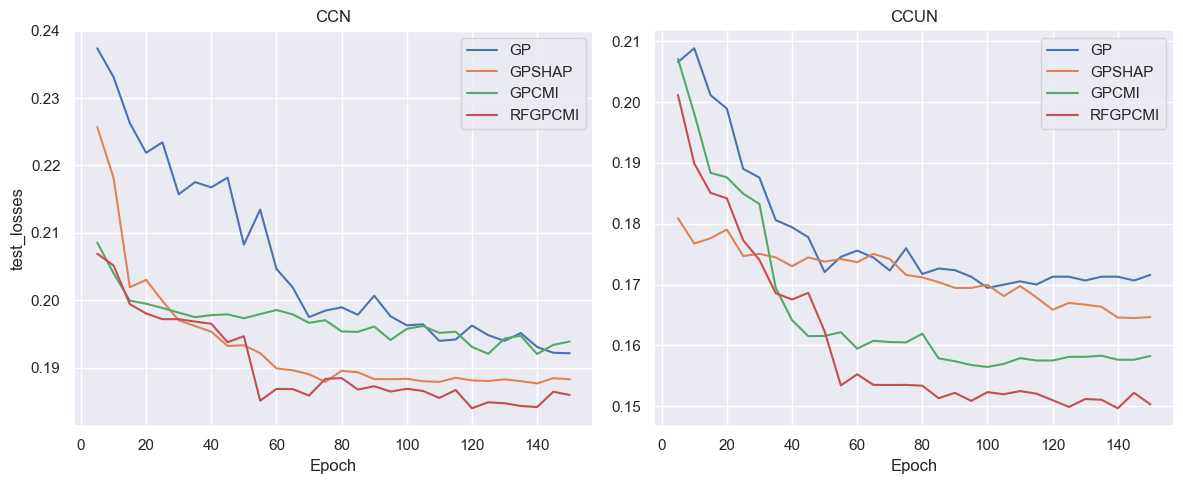

In [9]:
# metrics = 'training_losses'
# metrics = 'validation_losses'
metrics = 'test_losses'
n_datasets = len(results)
record_interval = gp_params['record_interval']

fig, axes = plt.subplots(1, n_datasets, figsize=(6 * n_datasets, 5))

if n_datasets == 1:
    axes = [axes]  # Ensure axes is always iterable

for ax, (dataset_name, dataset_results) in zip(axes, results.items()):
    # Get the number of intervals from any method (they should all be the same)
    method = next(iter(dataset_results))
    length = len(dataset_results[method][metrics].mean(axis=0))

    for method in dataset_results.keys():
        ax.plot(
            range(record_interval, length * record_interval + 1, record_interval),
            np.median(dataset_results[method][metrics], axis=0),
            # dataset_results[method][metrics][0],
            label=method
        )
    ax.set_title(dataset_name)
    ax.set_xlabel("Epoch")
    # ax.set_yscale("log")
    ax.legend()

axes[0].set_ylabel(metrics)
# axes[0].set_ylim((0, 0.001))
plt.tight_layout()

plt.show()

In [7]:
from copy import deepcopy

results_copy = deepcopy(results)

for dataset_name in results.keys():
    for method in results[dataset_name].keys():
        for metric in results[dataset_name][method].keys():
            results_copy[dataset_name][method][metric] = results[dataset_name][method][metric][:, -1]

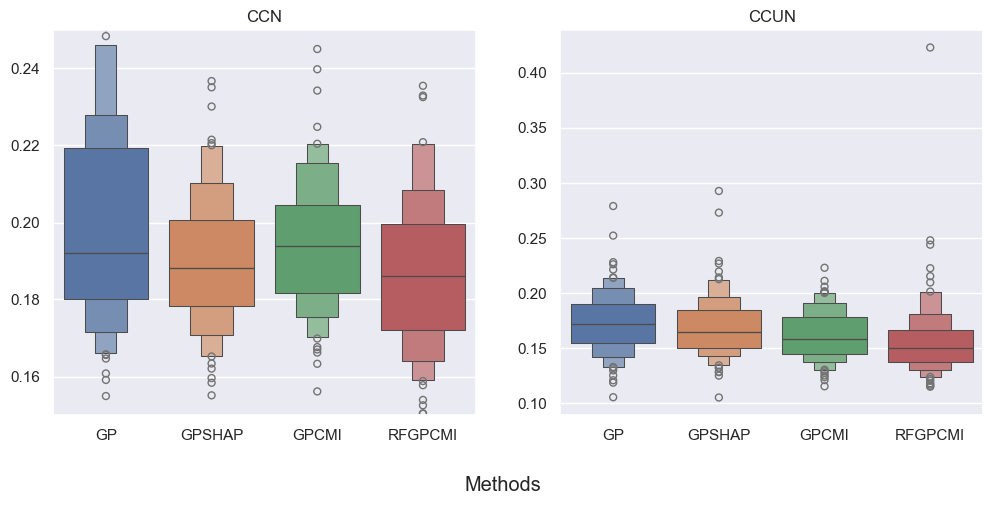

In [8]:
# Convert results to DataFrame    
df_results = results_to_dataframe(results_copy)

fig, axes = plot_results(
    df_results, 
    # nrows=2, 
    # ncols=None, 
    # group_level="model",
    # value_level="metric", 
    value_key="test_losses"
    # value_key="validation_losses",
    # value_key="training_losses"
)

fig.figure.set_size_inches(12, 5)
# fig.tight_layout(w_pad=0.5)
# fig.suptitle("Test Loss for Different Methods", y=1.04)
# fig.supylabel("Test Loss", x=-.02)
fig.supxlabel("Methods", y=-.05)

# axes[0].set_ylim(-.00001, 0.001)
# axes[1].set_ylim(.0, 0.1)
# axes[2].set_ylim(.1, 0.18)
axes[0].set_ylim(0.15, 0.25)
plt.show()

In [9]:
print('Mean Unique Features per Method')
print('-------------------------------\n')

for dataset_name in features.keys():
    print(f"{dataset_name} features:")

    for method in features[dataset_name].keys():
        list_of_lists = features[dataset_name][method]

        if isinstance(list_of_lists[0][0], str):
            a = [len(alist) for alist in list_of_lists]

        else:
            a = [len(set([item for sublist in alist for item in sublist])) for alist in list_of_lists]
        
        print(f"{method}: {np.mean(a):.2f} ± {np.std(a):.2f}")
    print()
            

Mean Unique Features per Method
-------------------------------

CCN features:
GP: 122.00 ± 0.00
GPSHAP: 7.00 ± 0.00
GPCMI: 5.79 ± 2.36
RFGPCMI: 13.73 ± 5.30



In [14]:
df_results

dataset              F1                                                \
method               GP                                        GPSHAP   
metric  training_losses validation_losses test_losses training_losses   
run                                                                     
0              0.189164          0.285199    0.216083        0.310804   
1              0.239481          0.284057    0.373323        0.270792   

dataset                                           CCN                    \
method                                             GP                     
metric  validation_losses test_losses training_losses validation_losses   
run                                                                       
0                0.377519    0.342343         0.27112          0.194753   
1                0.324099    0.418346         0.23012          0.258480   

dataset                                                            
method                       GPSHAP                                
metric  test_losses training_losses validation_losses test_losses  
run                                                                
0          0.219223        0.220779          0.176588    0.207203  
1          0.293799        0.236311          0.232233    0.261820

In [63]:
os.path.dirname(os.path.abspath(__file__))

NameError: name '__file__' is not defined

In [65]:
import os
os.path.abspath('')

'c:\\Users\\kevin\\OneDrive\\Desktop\\test\\Symbolic-Regression-Genetic-Programming\\notebooks'

In [73]:
import datetime
datetime.datetime.now().strftime(r"%Y%m%d%H%M%S")

'20250903084801'

In [81]:
a = []

if a is not None:
    print('yes')

yes


In [4]:
import pickle

data_gp = pickle.load(open("results_CCN_GP_0.pkl", "rb"))
data_shap = pickle.load(open("results_CCUN_GPSHAP_0.pkl", "rb"))

In [22]:
from pympler import asizeof

print(f"{asizeof.asizeof(data_gp) / (1024 * 1024):.2f} MB")
print(f"{asizeof.asizeof(data_shap) / (1024 * 1024):.2f} MB")

0.13 MB
0.12 MB


In [20]:
pip install pympler

Note: you may need to restart the kernel to use updated packages.


In [57]:
import re, os

logfile = "logfile.log"
started = set()
completed = set()

with open(logfile, encoding="utf-8") as f:
    for line in f:
        m = re.match(r"(Starting|Completed): (\w+) - (\w+) - Run (\d+)", line.strip())
        if m:
            kind, dataset, method, run = m.groups()
            key = (dataset, method, int(run))
            if kind == "Starting":
                started.add(key)
            else:
                completed.add(key)

pending = sorted(started - completed)
not_started_ccn_gpshap = [(d,m,r) for (d,m,r) in [( "CCN","GPSHAP",i) for i in range(30)] if (d,m,r) not in started]

print("Pending (started but not completed):", pending)
print("Not started CCN GPSHAP runs:", not_started_ccn_gpshap)

Pending (started but not completed): [('CCN', 'GP', 11), ('CCN', 'GPCMI', 25), ('CCN', 'RFGPCMI', 25)]
Not started CCN GPSHAP runs: [('CCN', 'GPSHAP', 0), ('CCN', 'GPSHAP', 1), ('CCN', 'GPSHAP', 2), ('CCN', 'GPSHAP', 3), ('CCN', 'GPSHAP', 4), ('CCN', 'GPSHAP', 5), ('CCN', 'GPSHAP', 6), ('CCN', 'GPSHAP', 7), ('CCN', 'GPSHAP', 8), ('CCN', 'GPSHAP', 9), ('CCN', 'GPSHAP', 10), ('CCN', 'GPSHAP', 11), ('CCN', 'GPSHAP', 12), ('CCN', 'GPSHAP', 13), ('CCN', 'GPSHAP', 14), ('CCN', 'GPSHAP', 15), ('CCN', 'GPSHAP', 16), ('CCN', 'GPSHAP', 17), ('CCN', 'GPSHAP', 18), ('CCN', 'GPSHAP', 19), ('CCN', 'GPSHAP', 20), ('CCN', 'GPSHAP', 21), ('CCN', 'GPSHAP', 22), ('CCN', 'GPSHAP', 23), ('CCN', 'GPSHAP', 24), ('CCN', 'GPSHAP', 25), ('CCN', 'GPSHAP', 26), ('CCN', 'GPSHAP', 27), ('CCN', 'GPSHAP', 28), ('CCN', 'GPSHAP', 29)]


In [38]:
completed

{('CCN', 'GP', 0),
 ('CCN', 'GP', 1),
 ('CCN', 'GP', 2),
 ('CCN', 'GP', 3),
 ('CCN', 'GP', 4),
 ('CCN', 'GP', 5),
 ('CCN', 'GP', 6),
 ('CCN', 'GP', 7),
 ('CCN', 'GP', 8),
 ('CCN', 'GP', 9),
 ('CCN', 'GP', 10),
 ('CCN', 'GP', 11),
 ('CCN', 'GP', 12),
 ('CCN', 'GP', 13),
 ('CCN', 'GP', 15),
 ('CCN', 'GP', 16),
 ('CCN', 'GP', 17),
 ('CCN', 'GP', 18),
 ('CCN', 'GP', 19),
 ('CCN', 'GP', 20),
 ('CCN', 'GP', 21),
 ('CCN', 'GP', 22),
 ('CCN', 'GP', 23),
 ('CCN', 'GP', 24),
 ('CCN', 'GP', 25),
 ('CCN', 'GP', 26),
 ('CCN', 'GP', 27),
 ('CCN', 'GP', 28),
 ('CCN', 'GP', 29),
 ('CCN', 'GPCMI', 0),
 ('CCN', 'GPCMI', 1),
 ('CCN', 'GPCMI', 2),
 ('CCN', 'GPCMI', 3),
 ('CCN', 'GPCMI', 4),
 ('CCN', 'GPCMI', 5),
 ('CCN', 'GPCMI', 6),
 ('CCN', 'GPCMI', 7),
 ('CCN', 'GPCMI', 8),
 ('CCN', 'GPCMI', 9),
 ('CCN', 'GPCMI', 10),
 ('CCN', 'GPCMI', 11),
 ('CCN', 'GPCMI', 12),
 ('CCN', 'GPCMI', 13),
 ('CCN', 'GPCMI', 15),
 ('CCN', 'GPCMI', 16),
 ('CCN', 'GPCMI', 17),
 ('CCN', 'GPCMI', 18),
 ('CCN', 'GPCMI', 19),
 ('

In [1]:
from symbolic_regression.methods.gp import GP

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [1]:
import pickle
import warnings
import sympy as sp

warnings.filterwarnings("ignore", category=UserWarning, module="pysr")


# def inv_sympy(x, evaluate=True):
#     return 1 / x

# def sqrt_sympy(x, evaluate=True):
#     return sp.sqrt(x, evaluate=evaluate)

def inv(x):
    return 1 / x

parameters = pickle.load(open('parameters.pkl', "rb"))

dataset_name = parameters['dataset_name']
method_name = parameters['method_name']
run = parameters['run']
train_val_test_set = parameters['train_val_test_set']
method = parameters['method']
output_dir = parameters['output_dir']
return_results = parameters['return_results']


if method_name == 'RFGPCMI':
    method.method_params['verbosity'] = 0
method.pysr_params['verbosity'] = 1


method.pysr_params['extra_sympy_mappings'] = {
    "inv": lambda x, evaluate=True: 1/x,
    "sqrt": lambda x, evaluate=True: sp.sqrt(x, evaluate=evaluate)
}
print(method.pysr_params)

temp_losses, temp_best_eqs, temp_features = method.run(train_val_test_set)

print()

if type(temp_best_eqs[-1]) == list:
    print(temp_best_eqs[-1][-1])
    
else:
    print(temp_best_eqs[-1])
print(temp_losses[2][-5:])

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
{'populations': 3, 'population_size': 33, 'niterations': 150, 'binary_operators': ['+', '-', '*'], 'unary_operators': ['sqrt', 'inv(x) = 1/x'], 'extra_sympy_mappings': {'inv': <function <lambda> at 0x0000022DF4A3C860>, 'sqrt': <function <lambda> at 0x0000022DFFDC1580>}, 'verbosity': 1, 'parallelism': 'serial', 'deterministic': True, 'input_stream': 'devnull', 'random_state': 272}


Compiling Julia backend...
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.072e-02  1.594e+01  y = 0.4556
2           5.695e-02  2.165e-01  y = sqrt(racepctblack)
3           4.507e-02  2.339e-01  y = PctIlleg * 0.89464
4           3.856e-02  1.560e-01  y = sqrt(PctIlleg) * 0.71903
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs\20250918_091309_COhcYw\hall_of_fame.csv


[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.543e-02  1.594e+01  y = 0.42811
2           5.808e-02  2.613e-01  y = sqrt(racepctblack)
3           4.207e-02  3.225e-01  y = PctIlleg * 0.89464
4           3.469e-02  1.929e-01  y = sqrt(MalePctDivorce * PctIlleg)
6           3.296e-02  2.565e-02  y = sqrt(MalePctDivorce * PctIlleg) * 0.9194
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs\20250918_091309_COhcYw\hall_of_fame.csv


[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.163e-02  1.594e+01  y = 0.43036
2           5.609e-02  2.446e-01  y = sqrt(PctPolicBlack)
3           3.778e-02  3.950e-01  y = PctIlleg * 0.90252
4           3.228e-02  1.574e-01  y = sqrt(MalePctDivorce * PctIlleg)
5           3.201e-02  8.350e-03  y = (PctIlleg * TotalPctDiv) + 0.1444
6           3.065e-02  4.347e-02  y = sqrt((MalePctDivorce * 0.84965) * PctIlleg)
8           2.993e-02  1.181e-02  y = sqrt((0.23145 + (PctUnemployed * MalePctDivorce)) * Pc...
                                      tIlleg)
9           2.806e-02  6.478e-02  y = sqrt((NumImmig + sqrt(PctUnemployed)) * (MalePctDivorc...
                                      e * PctIlleg))
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs\20250918_091309_COhcYw\hall_of_fame.csv


[ Info: Started!
[ Info: Final population:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.296e-02  1.594e+01  y = 0.43188
2           5.624e-02  2.603e-01  y = sqrt(NumIlleg)
3           3.873e-02  3.731e-01  y = PctIlleg * 0.90252
4           3.310e-02  1.570e-01  y = sqrt(MalePctDivorce * PctIlleg)
5           3.304e-02  1.824e-03  y = (PctIlleg * TotalPctDiv) + 0.14421
6           3.073e-02  7.227e-02  y = sqrt((FemalePctDiv * PctIlleg) * 0.81159)
9           2.825e-02  2.815e-02  y = sqrt((NumImmig + sqrt(PctUnemployed)) * (MalePctDivorc...
                                      e * PctIlleg))
21          2.759e-02  1.956e-03  y = sqrt(sqrt((PctIlleg * (sqrt(PctUnemployed * ((PctPersD...
                                      enseHous * ((MalePctDivorce + sqrt(PctRecImmig10)) * PersP...
                                      erOwnOccHous)) + PolicCars)) * MalePctDivorce)) * PctIlleg...
                                 

[ Info: Results saved to:
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.304e-02  1.594e+01  y = 0.43597
2           5.981e-02  1.997e-01  y = sqrt(NumIlleg)
3           3.982e-02  4.068e-01  y = PctIlleg * 0.90252
4           3.248e-02  2.038e-01  y = sqrt(MalePctDivorce * PctIlleg)
6           3.173e-02  1.176e-02  y = sqrt((FemalePctDiv * PctIlleg) * 0.81159)
7           3.170e-02  9.935e-04  y = sqrt((MalePctDivorce * sqrt(0.7466)) * PctIlleg)
8           3.138e-02  1.017e-02  y = sqrt((0.23145 + (PctUnemployed * MalePctDivorce)) * Pc...
                                      tIlleg)
9           2.875e-02  8.754e-02  y = sqrt((NumImmig + sqrt(PctUnemployed)) * (MalePctDivorc...
                                      e * PctIlleg))
13          2.862e-02  1.109e-03  y = sqrt((sqrt(sqrt(NumUnderPov * PersPerOwnOccHous) + sqr...
                                      t(NumUnderPov)) * PctIlleg) * MalePctDi

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.326e-02  1.594e+01  y = 0.43597
2           5.627e-02  2.638e-01  y = sqrt(PctPolicBlack)
3           4.079e-02  3.218e-01  y = PctIlleg * 0.9151
4           3.314e-02  2.077e-01  y = sqrt(MalePctDivorce * PctIlleg)
6           3.177e-02  2.108e-02  y = sqrt((FemalePctDiv * PctIlleg) * 0.81159)
8           3.147e-02  4.770e-03  y = sqrt(((PctIlleg * FemalePctDiv) - 0.0055943) * 0.88687...
                                      )
9           2.949e-02  6.501e-02  y = sqrt((NumImmig + sqrt(PctUnemployed)) * (MalePctDivorc...
                                      e * PctIlleg))
13          2.826e-02  1.064e-02  y = sqrt(sqrt(((MalePctDivorce * PctIlleg) * PctIlleg) * (...
                                      PolicCars + (PctUnemployed * MalePctDivorce))))
14          2.754e-02  2.589e-02  y = sqrt(sqrt(((PolicCars + (PctUnemployed * s

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.855e-02  1.594e+01  y = 0.43597
2           4.848e-02  3.464e-01  y = sqrt(NumIlleg)
3           3.966e-02  2.008e-01  y = PctIlleg * 0.9151
4           3.221e-02  2.082e-01  y = FemalePctDiv * sqrt(PctIlleg)
6           3.057e-02  2.605e-02  y = sqrt((FemalePctDiv * PctIlleg) * 0.81159)
8           2.908e-02  2.507e-02  y = sqrt((MalePctDivorce * PctIlleg) * (NumImmig + 0.76374...
                                      ))
9           2.817e-02  3.167e-02  y = sqrt((NumImmig + sqrt(PctUnemployed)) * (MalePctDivorc...
                                      e * PctIlleg))
13          2.706e-02  1.005e-02  y = sqrt(sqrt((PctIlleg * PctIlleg) * (PolicCars + (MalePc...
                                      tDivorce * (PctPersDenseHous * PctUnemployed)))))
14          2.587e-02  4.493e-02  y = sqrt(sqrt(((PolicCars + (PctUnemployed * sqrt(

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.116e-02  1.594e+01  y = 0.43035
2           5.905e-02  1.866e-01  y = sqrt(PctPolicBlack)
3           4.207e-02  3.391e-01  y = PctIlleg * 0.90957
4           3.305e-02  2.413e-01  y = TotalPctDiv * sqrt(PctIlleg)
6           3.115e-02  2.962e-02  y = TotalPctDiv * sqrt(PctIlleg * 1.2874)
7           3.080e-02  1.119e-02  y = sqrt(sqrt(TotalPctDiv) * (TotalPctDiv * PctIlleg))
8           3.040e-02  1.319e-02  y = sqrt((MalePctDivorce * PctIlleg) * (NumImmig + 0.76374...
                                      ))
9           2.885e-02  5.240e-02  y = sqrt((NumImmig + sqrt(PctUnemployed)) * (MalePctDivorc...
                                      e * PctIlleg))
14          2.857e-02  1.914e-03  y = sqrt(sqrt(((PolicCars + (PctUnemployed * sqrt(PctPersD...
                                      enseHous))) * (MalePctDivorce * PctIlleg)) *

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.259e-02  1.594e+01  y = 0.4466
2           5.824e-02  2.202e-01  y = sqrt(PctPolicBlack)
3           4.054e-02  3.623e-01  y = PctIlleg * 0.90957
4           3.381e-02  1.817e-01  y = sqrt(MalePctDivorce * PctIlleg)
6           3.306e-02  1.124e-02  y = TotalPctDiv * sqrt(PctIlleg * 1.2874)
7           3.157e-02  4.604e-02  y = sqrt(sqrt(TotalPctDiv) * (TotalPctDiv * PctIlleg))
8           2.952e-02  6.702e-02  y = sqrt((MalePctDivorce * PctIlleg) * (NumImmig + 0.76374...
                                      ))
9           2.794e-02  5.516e-02  y = sqrt((NumImmig + sqrt(PctUnemployed)) * (MalePctDivorc...
                                      e * PctIlleg))
14          2.750e-02  3.151e-03  y = sqrt(sqrt((((PolicCars + PctUnemployed) * sqrt(PctPers...
                                      DenseHous)) * (MalePctDivorce * PctIlleg))

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.039e-02  1.594e+01  y = 0.43235
2           5.524e-02  2.424e-01  y = sqrt(NumIlleg)
3           4.269e-02  2.576e-01  y = PctIlleg * 0.88199
4           3.379e-02  2.338e-01  y = sqrt(PctPopUnderPov * PctIlleg)
6           3.244e-02  2.035e-02  y = sqrt(TotalPctDiv * PctIlleg) * 0.88436
7           3.208e-02  1.115e-02  y = sqrt(sqrt(TotalPctDiv) * (TotalPctDiv * PctIlleg))
8           2.990e-02  7.064e-02  y = sqrt((MalePctDivorce * PctIlleg) * (NumImmig + 0.76374...
                                      ))
9           2.775e-02  7.432e-02  y = sqrt((sqrt(NumStreet) + PctIlleg) * (agePct12t29 * Mal...
                                      ePctDivorce))
12          2.698e-02  9.435e-03  y = sqrt(sqrt(((MalePctDivorce * (sqrt(NumStreet) + PctPer...
                                      sDenseHous)) * PctIlleg) * PctIlleg))
14      

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.019e-02  1.594e+01  y = 0.44294
2           5.717e-02  2.053e-01  y = sqrt(racepctblack)
3           4.132e-02  3.246e-01  y = PctIlleg * 0.88199
4           3.241e-02  2.430e-01  y = sqrt(MalePctDivorce * PctIlleg)
6           3.100e-02  2.222e-02  y = sqrt(TotalPctDiv * PctIlleg) * 0.88436
7           3.009e-02  2.986e-02  y = sqrt(sqrt(TotalPctDiv) * (TotalPctDiv * PctIlleg))
8           2.951e-02  1.938e-02  y = sqrt(MalePctDivorce * (PctIlleg * (NumImmig + FemalePc...
                                      tDiv)))
9           2.899e-02  1.770e-02  y = sqrt((PctIlleg * MalePctDivorce) * sqrt(TotalPctDiv + ...
                                      NumImmig))
12          2.779e-02  1.412e-02  y = sqrt(sqrt(((MalePctDivorce * (sqrt(NumStreet) + PctPer...
                                      sDenseHous)) * PctIlleg) * PctIlleg))
14

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.402e-02  1.594e+01  y = 0.43513
2           5.346e-02  3.255e-01  y = sqrt(PctPolicBlack)
3           4.078e-02  2.707e-01  y = PctIlleg * 0.91044
4           3.267e-02  2.216e-01  y = sqrt(MalePctDivorce * PctIlleg)
6           3.163e-02  1.630e-02  y = (OfficAssgnDrugUnits + sqrt(PctIlleg)) * MalePctDivorc...
                                      e
7           3.081e-02  2.612e-02  y = sqrt((sqrt(TotalPctDiv) * TotalPctDiv) * PctIlleg)
8           2.985e-02  3.184e-02  y = sqrt(MalePctDivorce * (PctIlleg * (NumImmig + FemalePc...
                                      tDiv)))
9           2.713e-02  9.552e-02  y = sqrt((PctIlleg * MalePctDivorce) * (sqrt(MalePctDivorc...
                                      e) + NumStreet))
10          2.613e-02  3.762e-02  y = sqrt((PctIlleg * MalePctDivorce) * (NumStreet + sqrt(s...
            

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


  - outputs\20250918_091309_COhcYw\hall_of_fame.csv


[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.370e-02  1.594e+01  y = PctIlleg
3           3.875e-02  6.005e-02  y = PctIlleg * 0.86788
4           3.017e-02  2.503e-01  y = FemalePctDiv * sqrt(PctIlleg)
6           2.837e-02  3.071e-02  y = (FemalePctDiv * sqrt(PctIlleg)) * 1.0984
8           2.736e-02  1.807e-02  y = sqrt((PctIlleg * MalePctDivorce) * sqrt(sqrt(PctPersDe...
                                      nseHous)))
10          2.499e-02  4.537e-02  y = sqrt((PctIlleg * MalePctDivorce) * (NumStreet + sqrt(s...
                                      qrt(PctPersDenseHous))))
14          2.404e-02  9.707e-03  y = sqrt((sqrt(NumStreet + sqrt(PctPersDenseHous + PctPoli...
                                      cAsian)) * PctIlleg) * (MalePctDivorce * pctUrban))
23          2.305e-02  4.650e-03  y = sqrt(sqrt((MalePctDivorce * (PctIlleg * sqrt((NumStree...
                    

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.492e-02  1.594e+01  y = PctIlleg
3           4.253e-02  2.726e-02  y = PctIlleg * 0.88888
4           3.325e-02  2.461e-01  y = FemalePctDiv * sqrt(PctIlleg)
5           3.247e-02  2.389e-02  y = (PctIlleg * TotalPctDiv) + 0.14421
6           2.965e-02  9.065e-02  y = sqrt(PctIlleg) * (FemalePctDiv * 1.142)
8           2.938e-02  4.608e-03  y = (PolicOperBudg * RentHighQ) + (FemalePctDiv * sqrt(Pct...
                                      Illeg))
9           2.668e-02  9.647e-02  y = sqrt((PctIlleg * MalePctDivorce) * (sqrt(MalePctDivorc...
                                      e) + NumStreet))
10          2.610e-02  2.204e-02  y = sqrt(PctIlleg * (MalePctDivorce * (NumStreet + sqrt(sq...
                                      rt(PctPersDenseHous)))))
14          2.555e-02  5.316e-03  y = sqrt(sqrt((MalePctDivorce * (sqrt(NumStreet)

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


  - outputs\20250918_091309_COhcYw\hall_of_fame.csv
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.358e-02  1.594e+01  y = PctIlleg
3           4.036e-02  3.841e-02  y = PctIlleg * 0.89311
4           3.108e-02  2.613e-01  y = sqrt(MalePctDivorce * PctIlleg)
6           2.938e-02  2.810e-02  y = sqrt((TotalPctDiv * PctIlleg) * 0.82258)
7           2.897e-02  1.416e-02  y = sqrt((sqrt(TotalPctDiv) * TotalPctDiv) * PctIlleg)
8           2.875e-02  7.478e-03  y = sqrt((PctIlleg * sqrt(sqrt(PctPopUnderPov))) * MalePct...
                                      Divorce)
9           2.810e-02  2.299e-02  y = sqrt(MalePctDivorce * ((sqrt(MalePctDivorce) + NumStre...
                                      et) * PctIlleg))
10          2.666e-02  5.237e-02  y = sqrt(MalePctDivorce * ((sqrt(sqrt(PctPersDenseHous)) +...
                                       NumStreet) * PctIlleg))
11        

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.484e-02  1.594e+01  y = PctIlleg
3           4.044e-02  5.162e-02  y = PctIlleg * 0.87134
4           3.353e-02  1.874e-01  y = sqrt(MalePctDivorce * PctIlleg)
6           3.072e-02  4.374e-02  y = sqrt((TotalPctDiv * PctIlleg) * 0.7674)
7           3.005e-02  2.192e-02  y = sqrt((PctIlleg * sqrt(PctHousLess3BR)) * TotalPctDiv)
8           2.984e-02  7.205e-03  y = sqrt((PctIlleg * sqrt(sqrt(PctPopUnderPov))) * MalePct...
                                      Divorce)
9           2.967e-02  5.823e-03  y = sqrt(MalePctDivorce * ((sqrt(MalePctDivorce) + NumStre...
                                      et) * PctIlleg))
10          2.693e-02  9.661e-02  y = sqrt(MalePctDivorce * ((sqrt(sqrt(PctPersDenseHous)) +...
                                       NumStreet) * PctIlleg))
14          2.501e-02  1.850e-02  y = sqrt(sqrt((PctPopUnder

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.374e-02  1.594e+01  y = PctIlleg
3           3.958e-02  4.999e-02  y = PctIlleg * 0.87134
4           3.223e-02  2.055e-01  y = sqrt(MalePctDivorce * PctIlleg)
5           3.186e-02  1.154e-02  y = (PctIlleg * TotalPctDiv) + 0.14421
6           2.968e-02  7.102e-02  y = sqrt(MalePctDivorce * PctIlleg) + -0.056701
7           2.871e-02  3.307e-02  y = sqrt((PctIlleg * sqrt(PctHousLess3BR)) * TotalPctDiv)
9           2.686e-02  3.338e-02  y = sqrt(MalePctDivorce * ((sqrt(MalePctDivorce) + NumStre...
                                      et) * PctIlleg))
10          2.436e-02  9.752e-02  y = sqrt((MalePctDivorce * (sqrt(sqrt(PctPersDenseHous)) +...
                                       NumStreet)) * PctIlleg)
14          2.407e-02  3.022e-03  y = sqrt(sqrt(PctIlleg * (((inv(MedOwnCostPctIncNoMtg) * (...
                              

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.329e-02  1.594e+01  y = PctIlleg
3           4.023e-02  3.667e-02  y = PctIlleg * 0.87134
4           3.194e-02  2.307e-01  y = sqrt(MalePctDivorce * PctIlleg)
6           3.072e-02  1.955e-02  y = sqrt(MalePctDivorce * PctIlleg) + -0.056701
7           2.929e-02  4.748e-02  y = sqrt((PctIlleg * sqrt(PctHousLess3BR)) * TotalPctDiv)
9           2.670e-02  4.644e-02  y = sqrt(PctPopUnderPov * (sqrt(NumStreet) + (PctIlleg * T...
                                      otalPctDiv)))
10          2.636e-02  1.272e-02  y = sqrt((sqrt(NumStreet) + PctIlleg) * (MalePctDivorce * ...
                                      sqrt(PctPopUnderPov)))
11          2.578e-02  2.205e-02  y = sqrt((PctIlleg * (MalePctDivorce * sqrt(PctPopUnderPov...
                                      ))) + (PctPopUnderPov * NumStreet))
12          2.474e-02  4.131e-02  

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.319e-02  1.594e+01  y = PctIlleg
3           4.064e-02  3.045e-02  y = PctIlleg * 0.90125
4           3.411e-02  1.750e-01  y = sqrt(MalePctDivorce * PctIlleg)
5           3.397e-02  4.203e-03  y = (PctIlleg * TotalPctDiv) + 0.14462
6           3.144e-02  7.730e-02  y = -0.056701 + sqrt(TotalPctDiv * PctIlleg)
7           3.055e-02  2.864e-02  y = sqrt((PctIlleg * sqrt(PctHousLess3BR)) * TotalPctDiv)
8           2.980e-02  2.500e-02  y = sqrt((PctIlleg + NumStreet) * (MalePctDivorce * 0.6834...
                                      2))
9           2.708e-02  9.562e-02  y = sqrt((PctIlleg + NumStreet) * (MalePctDivorce * sqrt(P...
                                      ctPopUnderPov)))
11          2.680e-02  5.178e-03  y = sqrt((PctIlleg * (MalePctDivorce * sqrt(PctPopUnderPov...
                                      ))) + (PctPopUnd

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.444e-02  1.594e+01  y = PctIlleg
3           4.114e-02  3.861e-02  y = PctIlleg * 0.89274
4           3.265e-02  2.311e-01  y = sqrt(MalePctDivorce * PctIlleg)
6           3.036e-02  3.628e-02  y = -0.056701 + sqrt(TotalPctDiv * PctIlleg)
7           2.958e-02  2.629e-02  y = sqrt((PctIlleg * sqrt(PctHousLess3BR)) * TotalPctDiv)
8           2.862e-02  3.300e-02  y = sqrt((PctIlleg + NumStreet) * (MalePctDivorce * 0.6834...
                                      2))
9           2.716e-02  5.232e-02  y = sqrt((PctIlleg + NumStreet) * (MalePctDivorce * sqrt(P...
                                      ctPopUnderPov)))
11          2.709e-02  1.308e-03  y = sqrt((sqrt(PctPopUnderPov) * (PctIlleg + NumStreet)) *...
                                       MalePctDivorce) * 1.0156
12          2.684e-02  9.060e-03  y = sqrt((PctIlleg * (MalePct

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.979e-02  1.594e+01  y = PctIlleg
3           3.620e-02  4.726e-02  y = PctIlleg * 0.88415
4           2.999e-02  1.881e-01  y = sqrt(MalePctDivorce * PctIlleg)
6           2.713e-02  5.017e-02  y = -0.056701 + sqrt(TotalPctDiv * PctIlleg)
7           2.594e-02  4.497e-02  y = sqrt(PctIlleg * (sqrt(PctHousLess3BR) * TotalPctDiv))
8           2.553e-02  1.599e-02  y = sqrt((PctIlleg + NumStreet) * (MalePctDivorce * 0.6834...
                                      2))
9           2.447e-02  4.233e-02  y = sqrt((PctIlleg + NumStreet) * (MalePctDivorce * sqrt(P...
                                      ctPopUnderPov)))
12          2.372e-02  1.035e-02  y = sqrt((PctIlleg * (MalePctDivorce * sqrt(PctPopUnderPov...
                                      ))) + (NumStreet * sqrt(LemasTotReqPerPop)))
15          2.084e-02  4.319e-02  y = sqrt(s

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.329e-02  1.594e+01  y = PctIlleg
3           3.898e-02  5.254e-02  y = PctIlleg * 0.88415
4           3.555e-02  9.196e-02  y = sqrt(MalePctDivorce * PctIlleg)
5           3.512e-02  1.215e-02  y = (PctIlleg * 0.69394) - -0.11604
6           3.197e-02  9.414e-02  y = -0.056701 + sqrt(TotalPctDiv * PctIlleg)
7           3.108e-02  2.808e-02  y = sqrt(PctIlleg * (sqrt(PctHousLess3BR) * TotalPctDiv))
8           3.032e-02  2.464e-02  y = sqrt((PctIlleg + NumStreet) * (MalePctDivorce * 0.6834...
                                      2))
9           2.894e-02  4.664e-02  y = sqrt((PctIlleg + NumStreet) * (MalePctDivorce * sqrt(P...
                                      ctPopUnderPov)))
12          2.884e-02  1.162e-03  y = sqrt((PctIlleg * (MalePctDivorce * sqrt(PctPopUnderPov...
                                      ))) + (NumStreet * 

[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:



complexity                                                 4
loss                                                 0.03008
equation                        sqrt(PctIlleg) * TotalPctDiv
score                                               0.196465
sympy_format                      sqrt(PctIlleg)*TotalPctDiv
lambda_format    PySRFunction(X=>sqrt(PctIlleg)*TotalPctDiv)
Name: 2, dtype: object
[0.18142202 0.1804781  0.18142202 0.18142202 0.19765105]
Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 4095: unexpected end of data

In [2]:
# [0.18142202 0.1804781  0.18142202 0.18142202 0.19765105]
print(temp_losses[2][-5:])
print(temp_best_eqs[-1].sympy_format)

[0.18142202 0.1804781  0.18142202 0.18142202 0.19765105]
sqrt(PctIlleg)*TotalPctDiv
Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 4095: unexpected end of data

In [23]:
print(temp_losses[0][:5])
print(temp_best_eqs[-1].sympy_format)

[0.2021125  0.2089249  0.24521026 0.20421226 0.22147601]
0.90277433 - PctKids2Par
